In [6]:
from classroom.datasets import InMemoryClipDataset, InMemoryPrefDataset
import numpy as np


ds = InMemoryClipDataset(
    '~/classroom/ant',
    filter_fn=lambda x: len(x.action) == 120,
    transform=lambda x: np.concatenate([x.state.obs, x.action], axis=1)
)
# ds = InMemoryPrefDataset(
#     '~/classroom/ant',
#     filter_fn=lambda x: len(x.action) == 120,
#     transform=lambda x: np.concatenate([x.state.obs, x.action], axis=1)
# )

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_len = round(len(ds) * 0.8)
train, val = random_split(ds, [train_len, len(ds) - train_len])

train_dl = DataLoader(train, batch_size=64, shuffle=True)
val_dl = DataLoader(val, batch_size=64)

In [ ]:
from imitation.algorithms.preference_comparisons import PreferenceComparisons



In [25]:
from itertools import pairwise
from torch import nn, Tensor
# from torch.nn.utils.parametrizations import spectral_norm
spectral_norm = lambda x: x


class TransformerPrefModel(nn.Module):
    def __init__(self, d_model: int, num_layers: int):
        super().__init__()
        assert d_model % 64 == 0, "d_model must be divisible by 64"

        self.input_linear = nn.LazyLinear(d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model, nhead=d_model // 64, dim_feedforward=d_model * 4,
                activation='gelu', batch_first=True, norm_first=True
            ),
            num_layers=num_layers
        )
        self.reward_linear = nn.Linear(d_model, 1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.input_linear(x)
        x = self.transformer(x)
        x = self.reward_linear(x)
        return x.flatten(1).sum(1)
    
    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        return self(a) - self(b)


In [1]:
import gpytorch as gp
import math
import matplotlib.pyplot as plt
import torch

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
test_x = torch.linspace(0, 1, 51)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.LinearMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RFFKernel(10))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gp.likelihoods.GaussianLikelihood()
model = ExactGPModel(None, None, likelihood)

In [2]:
model.eval()
likelihood(model(train_x)).log_prob(train_y)

tensor(-98.2980, grad_fn=<MulBackward0>)

In [79]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, 50, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.002   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.975   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.948   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.922   lengthscale: 0.555   noise: 0.555
Iter 5/50 - Loss: 0.899   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.877   lengthscale: 0.476   noise: 0.475
Iter 7/50 - Loss: 0.857   lengthscale: 0.441   noise: 0.438
Iter 8/50 - Loss: 0.839   lengthscale: 0.408   noise: 0.405
Iter 9/50 - Loss: 0.823   lengthscale: 0.378   noise: 0.374
Iter 10/50 - Loss: 0.809   lengthscale: 0.350   noise: 0.345
Iter 11/50 - Loss: 0.798   lengthscale: 0.324   noise: 0.319
Iter 12/50 - Loss: 0.789   lengthscale: 0.300   noise: 0.296
Iter 13/50 - Loss: 0.782   lengthscale: 0.277   noise: 0.275
Iter 14/50 - Loss: 0.776   lengthscale: 0.255   noise: 0.256
Iter 15/50 - Loss: 0.772   lengthscale: 0.235   noise: 0.240
Iter 16/50 - Loss: 0.767   lengthscale: 0.215   noise: 0.227
Iter 17/50 - Loss: 0.761   length

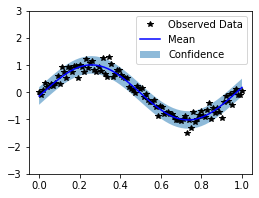

In [80]:
model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
from itertools import pairwise
from torch import nn, Tensor
import gpytorch as gp
# from torch.nn.utils.parametrizations import spectral_norm
spectral_norm = lambda x: x


class RFFGP(gp.models.ExactGP):
    def __init__(self, num_features: int, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RFFKernel(num_features))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

class GPLayer(gp.Module):
    def __init__(self, train_x = None, train_y = None, *, num_features: int = 1024):
        super().__init__()

        self.likelihood = gp.likelihoods.GaussianLikelihood()
        self.gp = RFFGP(num_features, train_x, train_y, likelihood = self.likelihood)

    def forward(self, x):
        return self.gp(x)


class BayesianPrefModel(nn.Module):
    def __init__(self, hiddens: list[int], latent_dim: int = 32):
        super().__init__()
        hiddens.append(latent_dim)

        self.hidden_layers = nn.Sequential()
        for i, j in pairwise(hiddens):
            self.hidden_layers.append(spectral_norm(nn.Linear(i, j)))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.1))

        self.hidden_layers.append(spectral_norm(nn.Linear(hiddens[-1], 1)))

    def forward(self, x: Tensor) -> Tensor:
        x = self.hidden_layers(x)
        return x.flatten(1).mean(1)

    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        return self(a) - self(b)


In [8]:
from itertools import pairwise
from torch import nn, Tensor
import gpytorch as gp
# from torch.nn.utils.parametrizations import spectral_norm
spectral_norm = lambda x: x


class MlpPrefModel(nn.Module):
    def __init__(self, hiddens: list[int]):
        super().__init__()

        # Normalize observations and actions to have mean 0 and std 1
        # self.obs_norm = nn.BatchNorm1d(hiddens[0])
        self.hidden_layers = nn.Sequential()

        for i, j in pairwise(hiddens):
            self.hidden_layers.append(spectral_norm(nn.Linear(i, j)))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.1))

        self.hidden_layers.append(spectral_norm(nn.Linear(hiddens[-1], 1)))
    
    def forward(self, x: Tensor) -> Tensor:
        # x = rearrange(x, 'n l c -> n c l')
        # x = self.obs_norm(x)
        # x = rearrange(x, 'n c l -> n l c')

        x = self.hidden_layers(x)
        return x.flatten(1).mean(1)
    
    def pref_logit(self, a: Tensor, b: Tensor) -> Tensor:
        return self(a) - self(b)


In [9]:
from torch import nn, Tensor
import torch

def permutation_loss(scores: Tensor, labels: Tensor) -> Tensor:
    # Sort predicted scores by their GT rewards/ranks, lowest to highest
    scores = scores[labels.argsort()]

    # We imagine that the GT ranking was generated sequentially in descending
    # order, by sampling *without replacement* from the available options in
    # proportion to exp(scores). The option set shrinks by one every time a
    # choice is made; e.g. the highest ranked option was selected from among the
    # entire set of options, the second highest from the whole set minus the
    # one just picked, etc. This allows us to efficiently compute the log-likelihood
    # of the GT ranking using a log-cumsum-exp trick.
    stabilizer = scores.max()
    exp_scores = torch.exp(scores - stabilizer)
    log_normalizer = exp_scores.cumsum(0).add(1e-7).log()

    return -torch.mean(scores - log_normalizer - stabilizer)

scores = nn.Parameter(torch.rand(11))
for i in range(1000):
    scores.grad = None

    loss = permutation_loss(scores, torch.arange(11))
    loss.backward()

    g = scores.grad
    with torch.no_grad():
        scores -= g

print(f"{scores.grad.norm()=}")

scores.grad.norm()=tensor(2.5007e-05)


In [10]:
from scipy.stats import kendalltau, rankdata, spearmanr
from torch.optim import AdamW
import torch
import torch.nn.functional as F


class RankCorrelation:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.scores = []
        self.labels = []
    
    def update(self, scores: Tensor, labels: Tensor) -> None:
        self.scores.append(scores.detach().cpu())
        self.labels.append(labels.detach().cpu())
    
    def compute(self):
        scores = np.concatenate(self.scores, axis=0)
        labels = np.concatenate(self.labels, axis=0)
        return kendalltau(scores, labels).correlation

rank_corr = RankCorrelation()

def fit(model, train_dl, val_dl):
    adam = AdamW(model.parameters())
    
    last_val_corr = -1.0
    while True:
        rank_corr.reset()
        model.train()
        
        train_losses = []
        for clip_batch, labels in train_dl:
            noised_labels = labels#  + torch.randn_like(labels) * torch.std(labels)
            loss = permutation_loss(
                model(clip_batch.cuda()), noised_labels.cuda()
            )
            loss.backward()

            adam.step()
            adam.zero_grad()
            train_losses.append(loss.detach().cpu())
        
        print(f"{np.mean(train_losses)=}")
        with torch.no_grad():
            model.eval()

            for clip_batch, rewards in val_dl:
                scores = model(clip_batch.cuda())
                rank_corr.update(scores, rewards)
        
        val_corr = rank_corr.compute()
        if val_corr < last_val_corr:
            break
        else:
            last_val_corr = val_corr

        print(f'val_corr: {val_corr.item():.4f}')

# model = TransformerPrefModel(256, 1).cuda()
model = MlpPrefModel([95, 32, 16]).cuda()
fit(model, train_dl, val_dl)

np.mean(train_losses)=2.9497359
val_corr: 0.9340
np.mean(train_losses)=2.1480603
val_corr: 0.9512
np.mean(train_losses)=1.5736381
val_corr: 0.9668
np.mean(train_losses)=1.5246235
val_corr: 0.9720
np.mean(train_losses)=1.512808
val_corr: 0.9743
np.mean(train_losses)=1.5120249
val_corr: 0.9769
np.mean(train_losses)=1.5055614
val_corr: 0.9776
np.mean(train_losses)=1.5073297
val_corr: 0.9776
np.mean(train_losses)=1.4960634
val_corr: 0.9792
np.mean(train_losses)=1.4944291


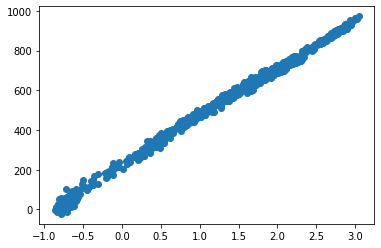

In [19]:
import matplotlib.pyplot as plt

plt.scatter(
    np.concatenate(rank_corr.scores, axis=0),
    np.concatenate(rank_corr.labels, axis=0),
)

(array([ 90.,  20.,  70., 107.,  85.,  92.,  78.,  55.,  70.,  85.]),
 array([-0.4168706 , -0.09938006,  0.21811047,  0.535601  ,  0.85309154,
         1.170582  ,  1.4880726 ,  1.8055631 ,  2.1230536 ,  2.4405441 ,
         2.7580347 ], dtype=float32),
 <BarContainer object of 10 artists>)

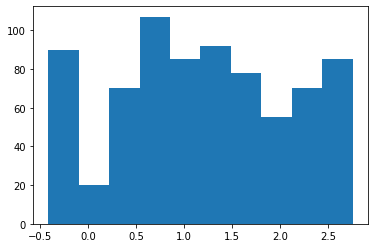

In [13]:
import matplotlib.pyplot as plt

plt.hist(np.concatenate(rank_corr.scores))

In [18]:
sum(param.numel() for param in model.parameters())

814593

In [44]:
np.concatenate(rank_corr.labels).shape

(752,)